# Generative adversarial network (GAN) implementation using PyTorch

In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from collections import OrderedDict, namedtuple
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn as nn
from PIL import Image
import glob
import pathlib
import cv2

In [4]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device

    def __iter__(self):
        for batch in self.data_loader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.data_loader)

In [6]:
mnist = MNIST(
    root="../data/",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=0.5, std=0.5),]),
)

In [7]:
IMAGE_SIZE = 28 * 28
HIDDEN_SIZE = 256
LATENT_SIZE = 64
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
N_EPOCHS = 300

In [33]:
data_loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)
data_loader = DeviceDataLoader(data_loader, get_default_device())

In [34]:
Model = namedtuple("Model", ["optimiser", "model", "loss"])

In [35]:
Discriminator = nn.Sequential(
    OrderedDict(
        [
            ("Input", nn.Linear(IMAGE_SIZE, HIDDEN_SIZE)),
            ("ReLu1", nn.LeakyReLU(0.2)),
            ("Linear1", nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)),
            ("ReLu2", nn.LeakyReLU(0.2)),
            ("Linear2", nn.Linear(HIDDEN_SIZE, 1)),
            ("Output", nn.Sigmoid()),
        ]
    )
)

Discriminator = Discriminator.to(get_default_device())
Discriminator = Model(
    loss=nn.BCELoss(),
    model=Discriminator,
    optimiser=torch.optim.Adam(Discriminator.parameters(), lr=LEARNING_RATE),
)

In [36]:
Generator = nn.Sequential(
    nn.Linear(LATENT_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, IMAGE_SIZE),
    nn.Tanh(),
)
Generator = Generator.to(get_default_device())
Generator = Model(
    loss=nn.BCELoss(),
    model=Generator,
    optimiser=torch.optim.Adam(Generator.parameters(), lr=LEARNING_RATE),
)

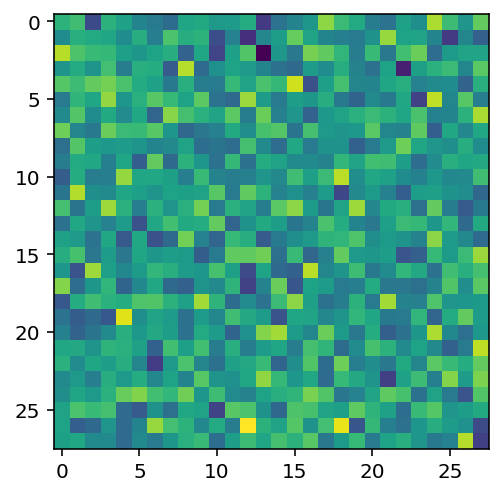

In [37]:
y = Generator.model(torch.randn(1, LATENT_SIZE))
plt.imshow(y.detach().numpy().reshape(28, 28))

In [38]:
def train_discriminator(
    Discriminator: Model, Generator: Model, Xb: torch.Tensor
) -> dict:
    real_labels = torch.ones(Xb.shape[0], 1).to(get_default_device())
    fake_labels = torch.zeros(Xb.shape[0], 1).to(get_default_device())

    # Loss form real images
    real_images_pred = Discriminator.model(Xb)
    loss_real_images = Discriminator.loss(real_images_pred, real_labels)

    # Loss from generated fake images
    z = torch.randn(Xb.shape[0], LATENT_SIZE).to(get_default_device())
    fake_images = Generator.model(z)
    fake_images_pred = Discriminator.model(fake_images)
    loss_fake_images = Discriminator.loss(fake_images_pred, fake_labels)

    # Combining losses
    loss = loss_real_images + loss_fake_images
    Discriminator.optimiser.zero_grad()
    Generator.optimiser.zero_grad()

    # Performing gradient descent
    loss.backward()
    Discriminator.optimiser.step()
    return {
        "loss": loss.cpu().detach().numpy().item(),
        "real_images_pred": real_images_pred,
        "fake_images_pred": fake_images_pred,
    }

In [39]:
def train_generator(Discriminator: Model, Generator: Model, batch_size: int) -> dict:
    z = torch.randn(batch_size, LATENT_SIZE).to(get_default_device())
    fake_images = Generator.model(z)
    labels = torch.ones(batch_size, 1).to(get_default_device())
    loss = Generator.loss(Discriminator.model(fake_images), labels)

    Discriminator.optimiser.zero_grad()
    Generator.optimiser.zero_grad()

    loss.backward()
    Generator.optimiser.step()
    return {"loss": loss.cpu().detach().numpy().item(), "fake_images": fake_images}

In [ ]:
fake_images = []
discriminator_loss = []
generator_loss = []
real_images_pred = []
fake_images_pred = []

for epoch in range(N_EPOCHS):
    _discriminator_loss = []
    _generator_loss = []
    _real_images_pred = []
    _fake_images_pred = []
    _fake_images = []
    
    for i, (Xb, _) in enumerate(data_loader):
        d_output = train_discriminator(Discriminator, Generator, Xb.reshape(Xb.shape[0], -1))
        g_output = train_generator(Discriminator, Generator, batch_size=BATCH_SIZE)
        
        _discriminator_loss.append(d_output["loss"])
        _generator_loss.append(g_output["loss"])
        _real_images_pred.append(d_output["real_images_pred"].mean().item())
        _fake_images_pred.append(d_output["fake_images_pred"].mean().item())
        
        print(
            (
                f"\rEpoch: {epoch + 1}/{N_EPOCHS} "
                + f"Step: {i + 1}/{len(data_loader)} "
                + f"D_loss: {_discriminator_loss[-1]:.4f} "
                + f"G_loss: {_generator_loss[-1]:.4f} "
                + f"Real_score: {_real_images_pred[-1]:.4f} "
                + f"Fake_score: {_fake_images_pred[-1]:.4f} "
            ),
            end=""
        )
    discriminator_loss.append(np.average(_discriminator_loss))
    generator_loss.append(np.average(_generator_loss))    
    real_images_pred.append(np.average(_real_images_pred))
    fake_images_pred.append(np.average(_fake_images_pred))
    fake_images.append(g_output["fake_images"])


In [ ]:
for i, images in enumerate(fake_images):
    image = make_grid(images.reshape(len(images), 1, 28, 28), padding=0)
    image = image.permute(1, 2, 0).cpu().detach().numpy()
    image = ((image + 1) * 255).astype(np.uint8)
    Image.fromarray(image).save(f"./data/image_{str(i).zfill(3)}.png")

In [5]:
files = glob.glob("../data/gan_images/*.png")
files = sorted(files, key=lambda p: int(pathlib.Path(p).stem.split("_")[1]))

In [6]:
video = cv2.VideoWriter(
    "../data/gan_evolution.avi", cv2.VideoWriter_fourcc(*"MJPG"), 8, (224, 224)
)
for file in files:
    video.write(cv2.imread(file))
    video.write(cv2.imread(file))
    video.write(cv2.imread(file))
    video.write(cv2.imread(file))
video.release()

In [111]:
# history = pd.DataFrame({
#     "discriminator_loss": discriminator_loss,
#     "generator_loss": generator_loss,
#     "real_images_pred": real_images_pred,
#     "fake_images_pred": fake_images_pred
# })
history = pd.read_csv("../data/gan-mnist-torch-history.csv")

In [119]:
pd.options.plotting.backend = "plotly"

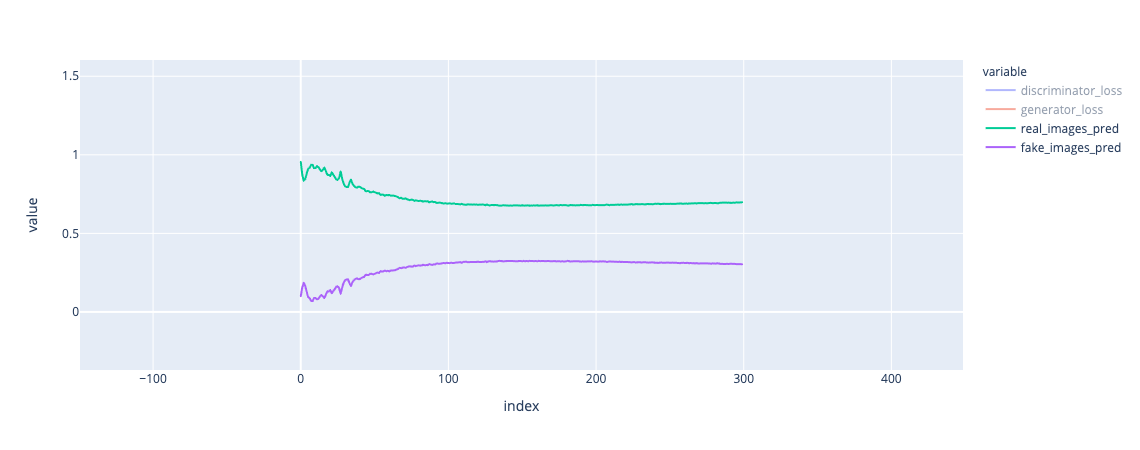

In [122]:
history.plot()

In [ ]:
torch.save(Discriminator.model.state_dict(), "../models/Discriminator-MNIST.pth")
torch.save(Generator.model.state_dict(), "../models/Generator-MNIST.pth")